# Aircraft Noise Impact Minimization

by Peter Sharpe

Here, we consider a case study where we wish to design a takeoff trajectory for a transport aircraft. 

In many cases near busy airports, noise pollution from departing flights is a major community impact that we want to minimize. When designing a trajectory with this in mind, there's an interesting trade-off to make:

* If we plan our initial climb with more throttle, this will increase the noise generated by the engines, and therefore, the community noise impact. However, this extra thrust will allow the aircraft to climb more quickly, so the duration of the impact will be less.
* On the other hand, if we plan to climb with lower throttle, the engines will operate more quietly, but the aircraft will spend more time low to the ground, closer to communities.

Since the community noise impact is a function of noise generation (i.e., engine power), noise attenuation (i.e., distance), and noise duration (i.e., total time spent flying low), it's not obvious what the best course of action is here.

Other complicating factors include:
* The distribution of population across the land is highly variable, so we likely want to change the trajectory to account for this.

However, this problem can be easily formulated and studied in relatively few lines of code using AeroSandbox.

## Assumptions

For simplicity, we'll make the following assumptions:

* The problem is two-dimensional (downrange distance and altitude).
* The aircraft flies at a constant speed: 220 knots indicated airspeed, which is typical for a transport aircraft and set by regulations)
* Excess power goes into climb rate, and the energy associated with velocity changes is small compared to those associated with altitude changes.

For the problem, we'll use an Earth-frame coordinate system where $(x_e, z_e) = (0, 0)$ is the takeoff point. $x_e$ represents the downrange distance and $z_e$ represents the vertical position (positive-down, by NED navigation convention.)

## Population Distribution Model

First, we make a model of the population distribution across the land. Let's simulate flying over a small city that is 10 km downrange of the takeoff point. We'll add a bit of uniform population everywhere, too. Assume no people live within 1 km of the airport.

In [39]:
import aerosandbox as asb
import aerosandbox.numpy as np
import aerosandbox.tools.units as u
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

In [40]:
def population_density_func(x_e):
    mean, std = 10e3, 3e3

    return np.where(
        x_e < 1e3,
        0,
        (
                np.exp(-0.5 * ((x_e - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
        ) + np.where(
            x_e < 25e3,
            0.2 / (25e3),
            0
        )
    )

This can be visualized as follows:

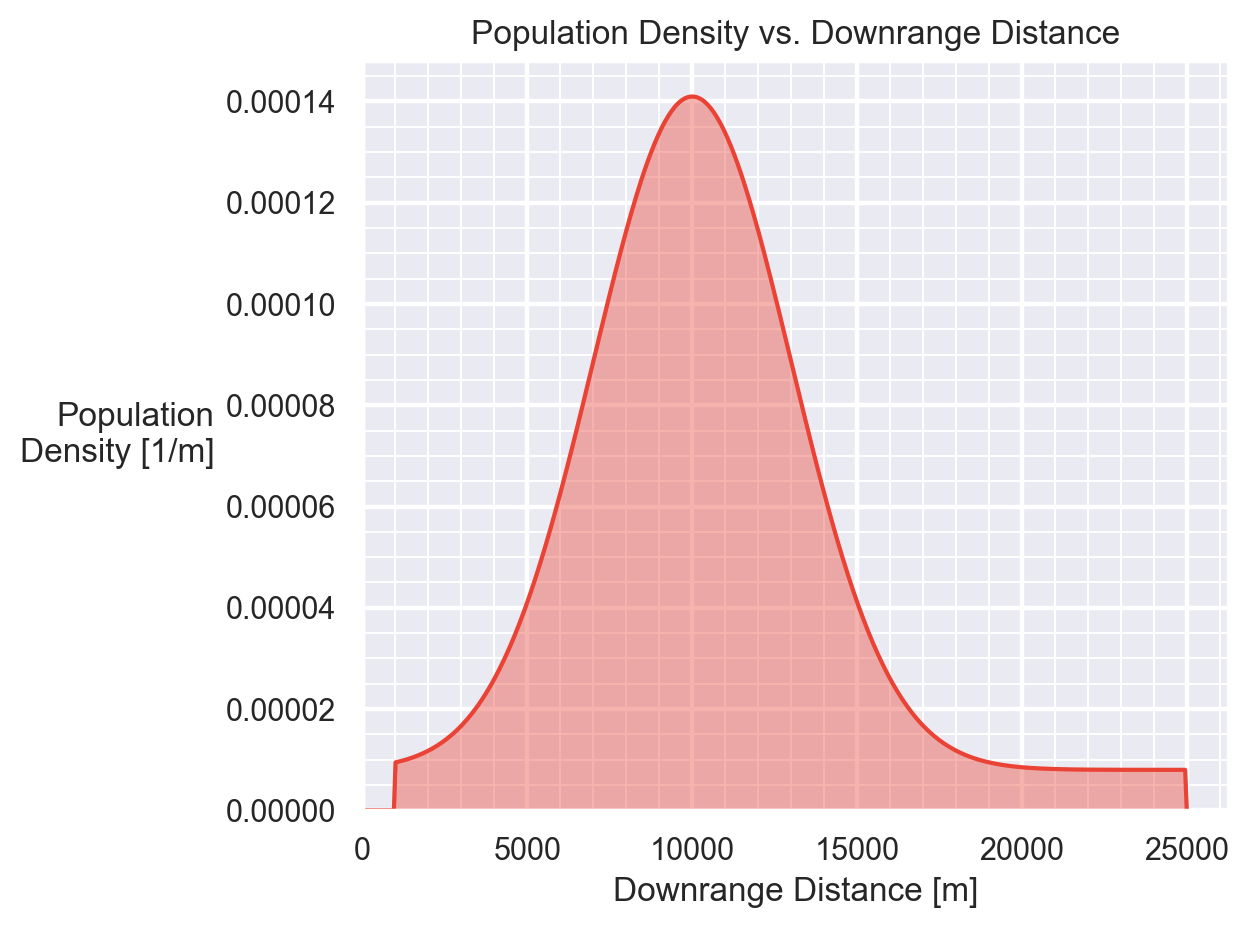

In [41]:
fig, ax = plt.subplots()


def plot_filled(x, y, color="C0"):
    plt.fill_between(
        x, 0, y,
        alpha=0.4,
        color=color
    )
    plt.plot(x, y, color=color)


plot_population_x_e = np.linspace(0, 25e3, 500)
plot_filled(
    plot_population_x_e,
    population_density_func(plot_population_x_e),
    color="C1"
)
plt.xlim(left=0)
plt.ylim(bottom=0)
p.show_plot(
    "Population Density vs. Downrange Distance",
    "Downrange Distance [m]",
    "Population Density [1/m]"
)

## Annoyance Function

Next, we set up a simple function that models the displeasure, or "annoyance", that airplane noise gives an individual person. We assume this function is "instantaneous", in that it models the amount of "annoyance per second" a person receives, which is then integrated over time to obtain the total annoyance.

In reality, this should be a function of:

* Generation (i.e., how much noise the aircraft makes)
* Attenuation (i.e., distance to the aircraft + atmospheric effects)
* Receptivity (i.e., how much the person cares about noise; whether they are inside or outside; time of day)

For simplicity, we'll make an easier model that is a function of throttle setting (generation) and distance (attenuation) only:

In [42]:
def annoyance_func(distance, throttle):
    return throttle ** 1.5 / ((distance + 100) / 1000) ** 2

Basically, this model says that:
* Noise generation is a slightly nonlinear function of throttle setting.
* Noise attenuation falls off as the square of distance (with a small offset that limits the annoyance at very close distances).

To get the total annoyance at any given time, we'll do a population-weighted integral of this annoyance function over the entire population distribution:

$$\text{Total Annoyance}(t=t_i) = \int_{x_e=0}^{x_e=\infty} \text{annoyance_func}(x_e, \text{throttle}) \cdot \text{population_density_func}(x_e) \, dx_e$$

This integral can be approximated as a sum over discrete points:

$$\text{Total Annoyance}(t=t_i) \approx \sum_{i=0}^{N} \text{annoyance_func}(x_{e,i}, \text{throttle}) \cdot \text{population_density_func}(x_{e,i}) \cdot \Delta x_e$$

where $\Delta x_e$ is the spacing between points.

Then, to get the total annoyance over the course of the flight, we'll integrate this over time:

$$\text{Total Annoyance} = \int_{t=0}^{t=\infty} \text{Total Annoyance}(t) \, dt$$

## Trajectory Optimization

Now, we set up the trajectory optimization problem. We'll use a simple model of the aircraft's performance that is a function of throttle setting and altitude. We'll optimize the throttle setting to minimize the total annoyance over the course of the flight.

In [46]:
population_x_e = np.linspace(0, 25e3, 51)
population_z_e = np.zeros_like(population_x_e)
population_density = population_density_func(population_x_e)

opti = asb.Opti()

N = 100  # Number of discretization points in time

### Set up the problem dynamics
mass_props_TOGW = asb.MassProperties(
    mass=73500  # kg; TOGW of Airbus A320
)
altitude = opti.variable(init_guess=np.linspace(10, 3e3, N))
atmo = asb.Atmosphere(altitude=altitude)
speed = 220 * u.knot * (atmo.density() / 1.225) ** 0.5  # True airspeed

dyn = asb.DynamicsPointMass2DSpeedGamma(
    mass_props=mass_props_TOGW,
    x_e=np.linspace(0, population_x_e[-1], N),
    z_e=-altitude,
    speed=speed,
    gamma=opti.variable(
        init_guess=np.zeros(N),
        lower_bound=-np.pi / 2,
        upper_bound=np.pi / 2
    ),
)

### Set up the thrust and climb dynamics
weight = mass_props_TOGW.mass * 9.81  # N

throttle = opti.variable(
    init_guess=0.8 * np.ones(N),
    lower_bound=0,
    upper_bound=1
)
dyn.throttle = throttle
TWR_max = 0.30  # Maximum takeoff thrust-to-weight ratio
thrust = throttle * (TWR_max * weight)  # N

LD = 12  # Assumed lift-to-drag ratio during climb
drag = weight / LD  # N

excess_thrust = thrust - drag  # N
excess_power = excess_thrust * dyn.speed  # W
excess_specific_power = excess_power / mass_props_TOGW.mass  # W/kg
climb_rate = excess_specific_power / 9.81  # Assumes all excess power goes into climbing

time = opti.variable(
    init_guess=dyn.x_e / (220 * u.knot),
)

opti.constrain_derivative(
    derivative=climb_rate,
    variable=dyn.altitude, with_respect_to=time,
    method='cubic',
)

### Constrain dynamics
opti.subject_to([
    time[0] == 0,
    dyn.altitude[0] == 50 * u.foot,
    dyn.altitude > 0,
    # np.mean(dyn.gamma) > np.radians(10),
])

dyn.constrain_derivatives(
    opti=opti,
    time=time,
    which=[
        "x_e", "z_e"
    ],
    method='cubic',
)

### Model noise
x_distances = np.tile(population_x_e, (N, 1)) - np.reshape(dyn.x_e, (N, 1))
z_distances = np.tile(population_z_e, (N, 1)) - dyn.z_e

distance = (
                   x_distances ** 2 +
                   z_distances ** 2
           ) ** 0.5
annoyances = annoyance_func(distance, throttle)
population_weighted_annoyance = np.mean(annoyances @ population_density)

### Model control complexity
from aerosandbox.numpy import integrate_discrete

complexity_func = lambda input: np.mean(
    integrate_discrete.integrate_discrete_squared_curvature(
        f=input,
        x=time,
    )
)

control_complexity = (
        complexity_func(throttle) +
        complexity_func(dyn.gamma)
)

opti.minimize(
    population_weighted_annoyance
    + 1e-3 * control_complexity
)

### Add in arbitrary constraints
opti.subject_to([
    # np.mean(dyn.gamma) > np.radians(5),
    # dyn.altitude[-1] > 5000 * u.foot,
    np.arctan2d(dyn.altitude, dyn.x_e) > 3,
])

sol = opti.solve(
    behavior_on_failure="return_last"
)

dyn = sol(dyn)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3548
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:     3546

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      299
Total number of inequality constraints...............:      600
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6369900e-04 3.50e+01 1.21e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

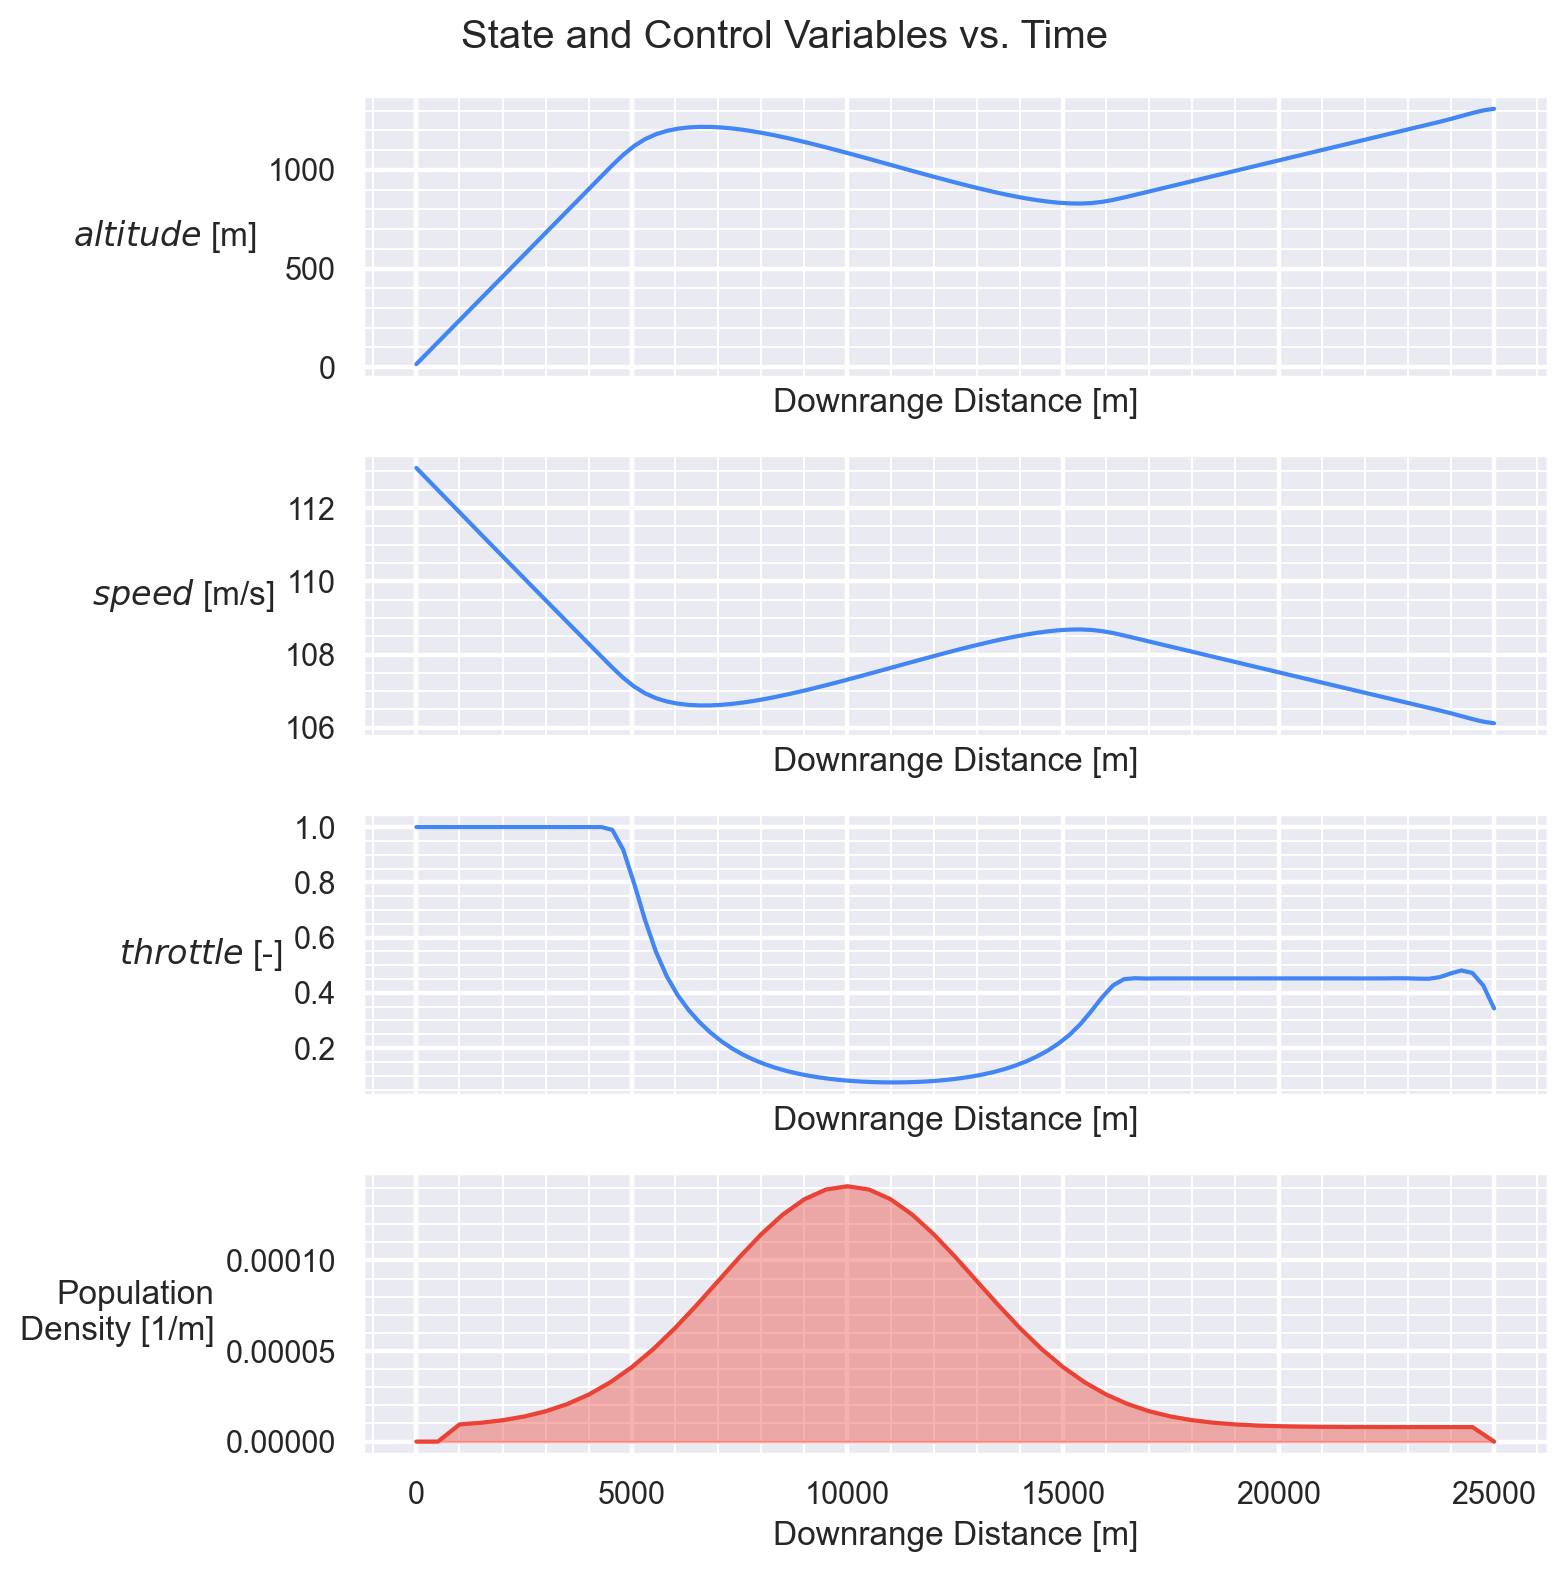

In [47]:

fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
ax_flattened = list(ax.flatten())
plt.sca(ax_flattened[0])


def plot(var_name, unit=""):
    ### Make the plot
    plt.plot(sol(dyn.x_e), getattr(dyn, var_name))
    plt.ylabel(f"${var_name}$ [{unit}]")

    ### And go to the next subplot, if applicable
    current_axis_id = ax_flattened.index(plt.gca())
    if not current_axis_id == len(ax_flattened) - 1:
        plt.sca(ax_flattened[current_axis_id + 1])


plot("altitude", "m")
plot("speed", "m/s")
plot("throttle", "-")

plt.sca(ax_flattened[-1])
plot_filled(population_x_e, population_density, color="C1")
plt.ylabel("Population Density [1/m]")

for a in ax_flattened:
    plt.sca(a)
    plt.xlabel("Downrange Distance [m]")

p.show_plot('State and Control Variables vs. Time')

As you can see, the aircraft initially climbs rapidly, then does a throttle cutback at around 10 km downrange (right on top of the population center), then climbs at a lower throttle setting to minimize the annoyance.

This trajectory can be visualized in 3D (interactively, if you're running this notebook locally) with a simple `dyn.draw()` command:

C:\Users\peter\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


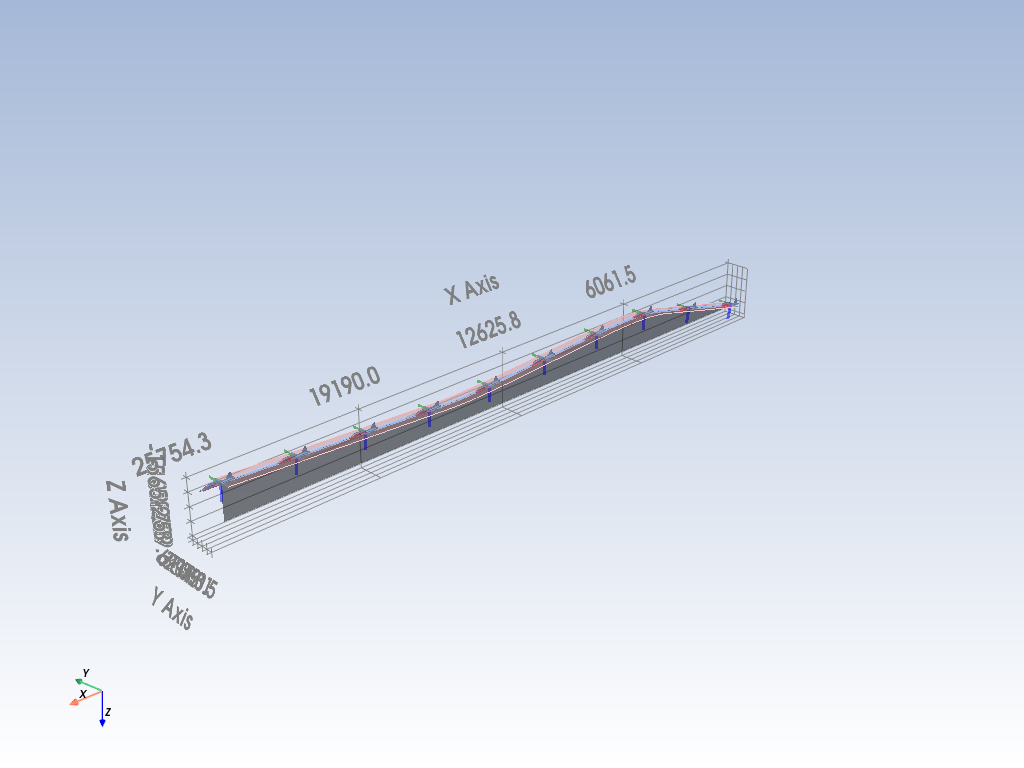

In [48]:
# NBVAL_SKIP

dyn.draw()